# Chapter 8 Exercises

# Set up

## Python path

In [2]:
from pathlib import Path
import sys

# Add the parent directory to the system path
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

## Packages

In [187]:
from csaps import csaps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix, build_design_matrices
import seaborn as sns
from scipy.optimize import minimize_scalar
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import const
import utils

## Constants

## Set defaults

In [4]:
utils.set_default_plot_style()

# Exercise 8.6

Consider the bone mineral density data of Figure 5.6.

(a) Fit a cubic smooth spline to the relative change in spinal BMD, as a function of age.
Use cross-validation to estimate the optimal amount of smoothing.
Construct pointwise 90% confidence bands for the underlying function.

(b) Compute the posterior mean and covariance for the true function via (8.28), and compare the posterior bands to those obtained in (a).

(c) Compute 100 bootstrap replicates of the fitted curves, as in the bottom left panel of Figure 8.2.
Compare the results to those obtained in (a) and (b).

### Solution

See Chapter 5 notes for an introduction to smoothing splines and the `csaps` package.

In [5]:
# Load the bone data
bone_data = pd.read_csv('../data/bone.data', sep='\s+')
bone_data.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


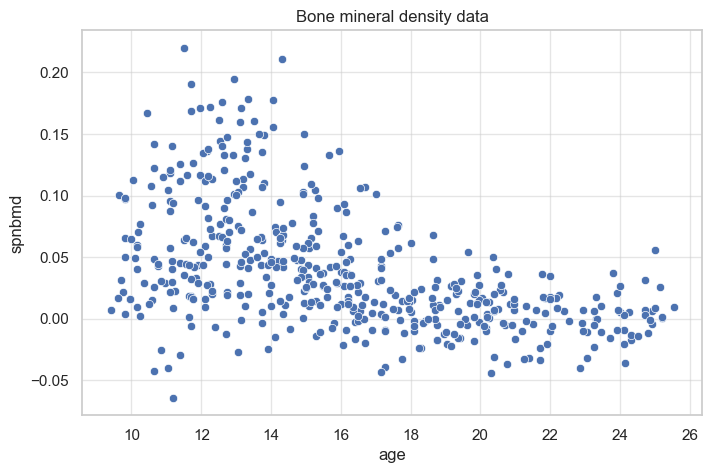

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(bone_data, x="age", y="spnbmd",ax=ax)
ax.set(title="Bone mineral density data");

The bone data has duplicate $x$-values so we need to deduplicate before fitting the smoothing spline:

In [ ]:
class CubicSmoothingSpline():
    def __init__(self, x, y, smooth=None):
        self.x = x
        self.y = y
        self.x_unique, self.y_means, self.weights = self._deduplicate_x_values(
            self.x, self.y
        )

        # Automatically optimize the smooth parameter if not provided
        if smooth is None:
            self.smooth, self.dof, self.cv_error = self.optimize_smoothing()
            print(f"Automatically selected smooth={self.smooth:.6f} (DoF={self.dof:.2f}, CV error={self..cv_error:.6f})")
        else:
            self.smooth = smooth
            self.dof = self._calculate_dof(smooth)
            self.cv_error = self.calculate_loo_cv_mse(smooth)

        self.smoother_matrix = self._calculate_smoother_matrix()
        self.y_pred = self.smoother_matrix @ self.y

    def _deduplicate_x_values(self, x, y):
        """Deduplicate x values and average corresponding y values with weights w."""
        df = pd.DataFrame(
            index=x,
            data=np.array(y).T
        )
        means = df.groupby(level=0).mean()
        sizes = df.groupby(level=0).size()
        
        # if y is 1d we want to return a 1d output
        if means.shape[1] == 1:
            means = means.squeeze()
        
        return means.index.values, means.values, sizes.values
    
    def predict(self, x_new=None):
        """Predict values at new x points or at training points if not provided."""
        if x_new is None:
            x_new = self.x

        return csaps(self.x_unique, self.y_means, x_new, smooth=self.smooth, weights=self.weights, axis=-1, normalizedsmooth=True)
    
    def _calculate_smoother_matrix(self, smooth=None):
        """Calculate the smoother matrix for the given smoothing parameter."""
        if smooth is None:
            smooth = self.smooth
        
        n = len(self.x)
        Y = np.identity(n)
        _, Y_means, _ = self._deduplicate_x_values(self.x, Y)
        A = csaps(self.x_unique, Y_means, self.x, weights=self.weights, smooth=smooth, axis=0 ,normalizedsmooth=True)
        return (A + A.T)/2

    def _calculate_dof(self, smooth=None):
        """Calculate the effective degrees of freedom."""
        if smooth is None:
            smooth = self.smooth
        
        smoother_matrix = self._calculate_smoother_matrix(smooth)
        return np.trace(smoother_matrix)

    def calculate_loo_cv_mse(self, smooth=None):
        """Calculate leave-one-out cross-validation mean squared error."""
        if smooth is None:
            smooth = self.smooth

        smoother_matrix = self._calculate_smoother_matrix(smooth)
        y_pred = smoother_matrix @ self.y
        return np.mean(((self.y - y_pred) / (1 - np.diagonal(smoother_matrix))) ** 2)
    
    def optimize_smoothing(self):
        res = minimize_scalar(self.calculate_loo_cv_mse, bounds=(0, 1))
        """Find optimal smoothing parameter using cross-validation."""
        smooth = res.x
        cv_error = res.fun
        dof = self._calculate_dof(smooth)
        return smooth, dof, cv_error
            
    def perform_grid_search(self, smooth_values=None, plot_results=True):
        """Perform grid search over smoothing parameters values."""
        if smooth_values is None:
            smooth_values = np.linspace(0, 1, 100)

        cv_errors = np.array([self.calculate_loo_cv_mse(smooth) for smooth in smooth_values])
        dof_values = np.array([self._calculate_dof(smooth) for smooth in smooth_values])

        self.search_smooth_values = smooth_values
        self.search_cv_errors = cv_errors
        self.search_dof_values = dof_values

        if plot_results:
            ax = self.plot_grid_search_results(smooth_values, cv_errors, dof_values)
        else:
            ax = None

        return smooth_values, cv_errors, ax
    
    def get_training_predictions_with_std_errors(self):
        """Get fitted predictions and standard errors at the training data points.
    
        Calculates predictions and pointwise standard errors for the training data
        points using the smoother matrix. Returns sorted arrays for convenient plotting.
        """
        # Calculate predictions
        y_pred = self.smoother_matrix @ self.y
        
        # Calculate standard errors
        covariance = self.smoother_matrix @ self.smoother_matrix.T
        vars = np.diagonal(covariance)
        std_errs = np.sqrt(vars) / np.sqrt(len(self.x))
        
        # Sort for plotting
        order = np.argsort(self.x)
        
        return self.x[order], y_pred[order], std_errs[order]
    
    def plot_training_predictions(self, confidence_level=None, spline_color=None, ax=None):
        """Plot the cubic smoothing spline."""
        if spline_color is None:
            spline_color = sns.color_palette()[1]
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 5))

        sns.scatterplot(x=self.x, y=self.y)

        x_sorted, y_pred, std_errs = self.get_training_predictions_with_std_errors()
        ax.plot(x_sorted, y_pred, color=spline_color)

        if confidence_level is not None:
            alpha = 1 - confidence_level
            z_score = norm.ppf(1 - alpha / 2)
            ax.fill_between(
                x_sorted, 
                y_pred - z_score * std_errs, 
                y_pred + z_score * std_errs, 
                color=spline_color,
                alpha=0.2,
            )

        ax.set(title="Cubic Smoothing Spline Fit")
        return ax


    def plot_grid_search_results(self, smooth_values, cv_errors, dof_values, ax=None):
        """Plot the results of the grid search.
        
        We plot smoothing values on the bottom x-axis and effective degrees of freedom on the top x-axis.
        """
        # Calculate degrees of freedom for each smoothing value
        if dof_values is None:
            dof_values = np.array([self._calculate_dof(smooth) for smooth in smooth_values])
        
        # Use interpolation to map between smoothing values and degrees of freedom
        def _smooth_to_dof(smooth_arr):
            return np.interp(smooth_arr, smooth_values, dof_values)
        
        def _dof_to_smooth(dof_arr):
            return np.interp(dof_arr, dof_values, smooth_values)
        
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(x=smooth_values, y=cv_errors, ax=ax)
        ax.set(
            xlabel="Smoothing Parameter",
            ylabel="Leave-One-Out CV MSE",
            title="Leave-One-Out Cross-Validation MSE"
        )

        secax = ax.secondary_xaxis('top', functions=(_smooth_to_dof, _dof_to_smooth))

        # Set ticks for the secondary x-axis at integer degrees of freedom
        int_dof_values = np.ceil(dof_values)
        dof_ticks = np.arange(np.min(int_dof_values), np.max(int_dof_values))
        secax.set(
            xticks=dof_ticks,
            xlabel="Effective Degrees of Freedom"
        )

        fig.tight_layout()

        return ax

Automatically selected smooth=0.001380 (DoF=6.83, CV error=0.001665)


<Axes: title={'center': 'Cubic Smoothing Spline Fit'}, xlabel='age', ylabel='spnbmd'>

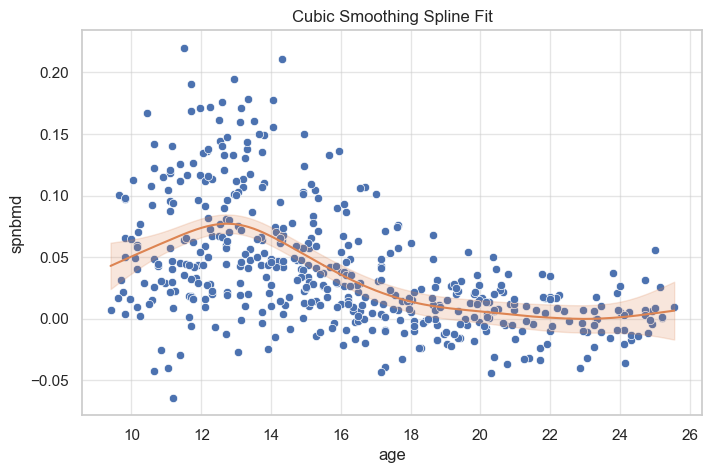

In [201]:
spline_model = CubicSmoothingSpline(bone_data['age'], bone_data['spnbmd'])
spline_model.plot_training_predictions(confidence_level=0.95)

Try smoother matrix

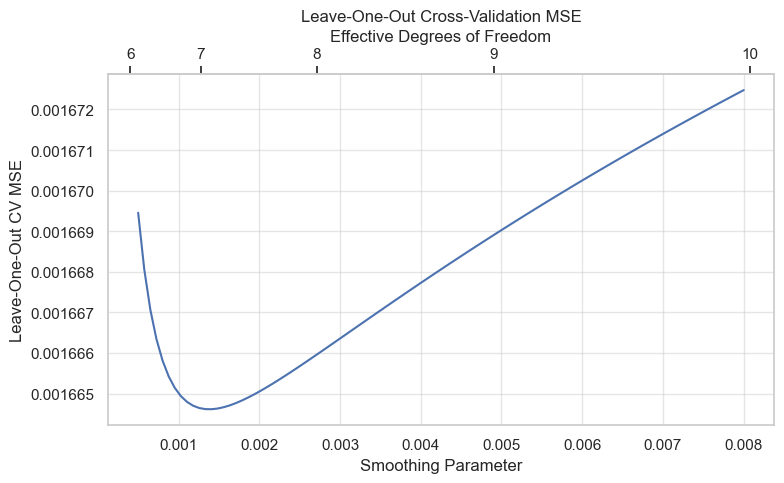

In [202]:
smooth_values = np.linspace(0.0005, 0.008, 100)
smooth_values, cv_errors, ax = spline_model.perform_grid_search(smooth_values)

In [127]:
spline_model.calculate_dof(smooth=0.002)

np.float64(7.399756757527946)

In [124]:
spline_model.calculate_dof(smooth=0.0025)

np.float64(7.770398376503339)

In [125]:
spline_model.calculate_dof(smooth=0.02)

np.float64(12.448448637895066)

In [61]:
spline_model = CubicSmoothingSpline(bone_data['age'], bone_data['spnbmd'])

def objective_function(smooth):
    """Objective function for optimization."""
    return spline_model.loo_cv_mse(smooth)
res = minimize_scalar(spline_model.loo_cv_mse, bounds=(0, 1), options={'return_all':True})

/var/folders/7x/ncnf85cs3wl2vf9nhdxk4cjw0000gp/T/ipykernel_4252/3168968567.py:6: OptimizeWarning: Unknown solver options: return_all
  res = minimize_scalar(spline_model.loo_cv_mse, bounds=(0, 1), options={'return_all':True})


In [82]:
res

 message: Solution found.
 success: True
  status: 0
     fun: 0.0018049475134413275
       x: 0.004232498353944981
     nit: 20
    nfev: 20

In [83]:
res.fun

np.float64(0.0018049475134413275)

In [57]:
dir(res)

['fun', 'message', 'nfev', 'nit', 'status', 'success', 'x']

In [59]:
from scipy.optimize import minimize

In [60]:
spline_model = CubicSmoothingSpline(bone_data['age'], bone_data['spnbmd'])

def objective_function(smooth):
    """Objective function for optimization."""
    return spline_model.loo_cv_mse(smooth)
res = minimize(spline_model.loo_cv_mse, bounds=(0, 1), options={'return_all':True})

TypeError: minimize() missing 1 required positional argument: 'x0'

Text(0, 0.5, 'Leave-One-Out CV MSE')

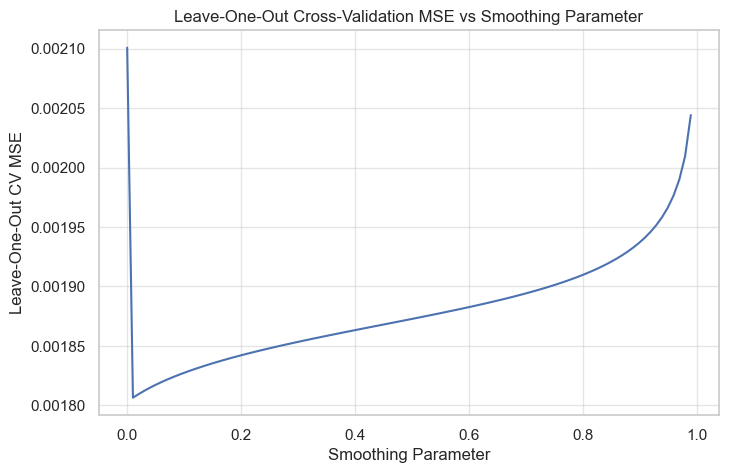

In [41]:
smooth_values, cv_errors = spline_model.grid_search_smooth()
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x=smooth_values, y=cv_errors, ax=ax)
ax.set(title="Leave-One-Out Cross-Validation MSE vs Smoothing Parameter")
ax.set_xlabel("Smoothing Parameter")
ax.set_ylabel("Leave-One-Out CV MSE")

Text(0, 0.5, 'Leave-One-Out CV MSE')

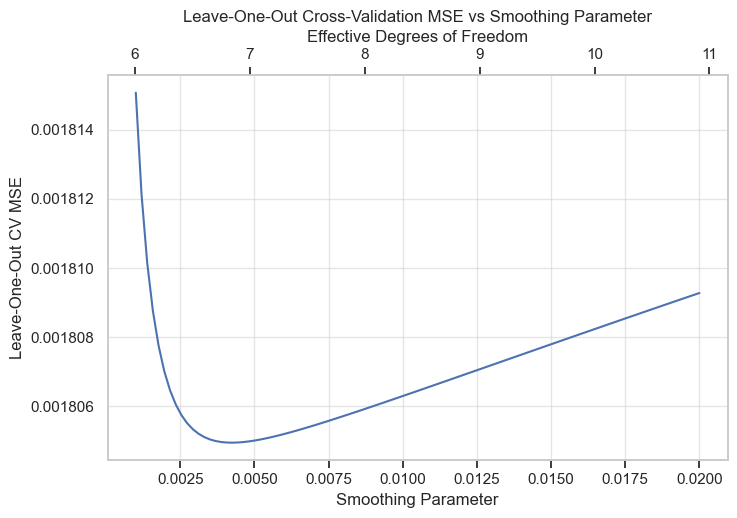

In [73]:
smooth_values = np.linspace(0.001, 0.02, 100)
dof_values = np.array([spline_model.calculate_dof(smooth) for smooth in smooth_values])
smooth_values, cv_errors = spline_model.grid_search_smooth(smooth_values)

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=smooth_values, y=cv_errors, ax=ax)

ax2 = ax.twiny()
ax2.set_xlim(dof_values[0], dof_values[-1])
ax2.invert_xaxis()
ax2.set(
    xlim=(dof_values[0], dof_values[-1]),
    xlabel="Effective Degrees of Freedom",
)
ax2.grid(False)

ax.set(title="Leave-One-Out Cross-Validation MSE vs Smoothing Parameter")
ax.set_xlabel("Smoothing Parameter")
ax.set_ylabel("Leave-One-Out CV MSE")

Text(0, 0.5, 'Leave-One-Out CV MSE')

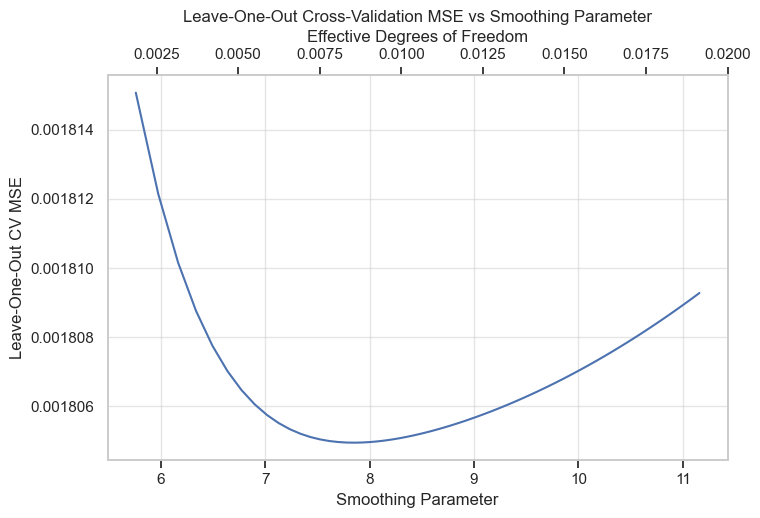

In [74]:
smooth_values = np.linspace(0.001, 0.02, 100)
dof_values = np.array([spline_model.calculate_dof(smooth) for smooth in smooth_values])
smooth_values, cv_errors = spline_model.grid_search_smooth(smooth_values)

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=dof_values, y=cv_errors, ax=ax)

ax2 = ax.twiny()
ax2.set_xlim(smooth_values[0], smooth_values[-1])
ax2.invert_xaxis()
ax2.set(
    xlim=(smooth_values[0], smooth_values[-1]),
    xlabel="Effective Degrees of Freedom",
)
ax2.grid(False)

ax.set(title="Leave-One-Out Cross-Validation MSE vs Smoothing Parameter")
ax.set_xlabel("Smoothing Parameter")
ax.set_ylabel("Leave-One-Out CV MSE")

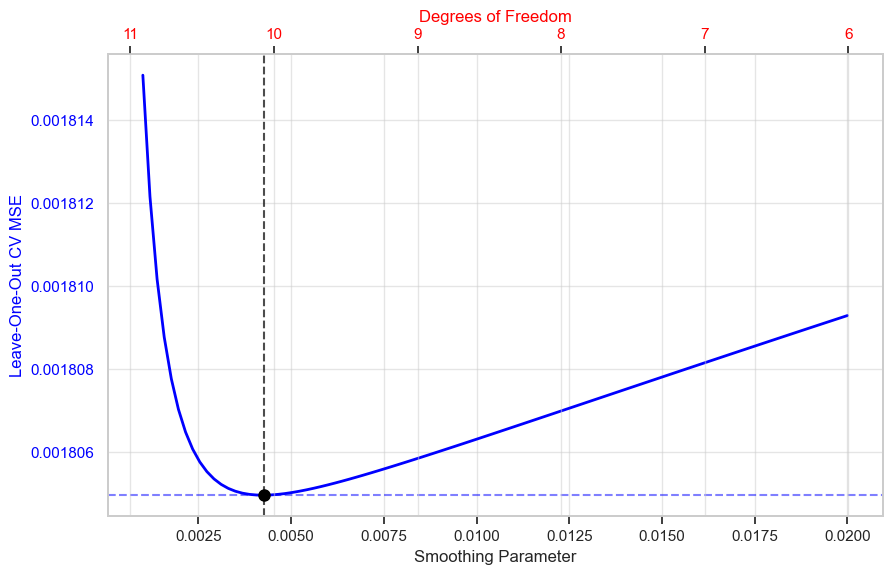

In [69]:
smooth_values = np.linspace(0.001, 0.02, 100)
dof_values = np.array([spline_model.calculate_dof(smooth) for smooth in smooth_values])
smooth_values, cv_errors = spline_model.grid_search_smooth(smooth_values)

# Find the optimal smooth value and corresponding dof
optimal_smooth = smooth_values[np.argmin(cv_errors)]
optimal_dof = spline_model.calculate_dof(optimal_smooth)
min_cv_error = np.min(cv_errors)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the CV error vs smooth parameter on the first x-axis
color1 = 'blue'
ax1.set_xlabel('Smoothing Parameter', fontsize=12)
ax1.set_ylabel('Leave-One-Out CV MSE', color=color1, fontsize=12)
ax1.plot(smooth_values, cv_errors, color=color1, lw=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axvline(x=optimal_smooth, color='black', linestyle='--', alpha=0.7)
ax1.axhline(y=min_cv_error, color=color1, linestyle='--', alpha=0.5)

# Create the second x-axis for the degrees of freedom
ax2 = ax1.twiny()
ax2.set_xlabel('Degrees of Freedom', color='red', fontsize=12)
ax2.tick_params(axis='x', labelcolor='red')

# Create a mapping between smooth_values and dof_values for the second x-axis
# We need to ensure both axes have the same data range
ax2.set_xlim(dof_values[0], dof_values[-1])
ax2.invert_xaxis()  # Higher smooth values correspond to lower dof

# Add a point marker at the optimal value
ax1.plot(optimal_smooth, min_cv_error, 'o', color='black', markersize=8)

In [45]:
smooth_values[np.argmin(cv_errors)]


np.float64(0.004242424242424242)

In [29]:
spline_model.calculate_smoother_matrix()

array([[ 1.60264558e-02, -6.89449649e-04,  1.74158412e-05, ...,
         1.58385660e-02,  5.03986480e-03,  3.68277937e-05],
       [-6.89449649e-04,  2.02119758e-02, -7.00061536e-04, ...,
        -7.74576737e-04, -1.10536554e-04, -1.42480470e-06],
       [ 1.74158412e-05, -7.00061536e-04,  1.89727389e-02, ...,
         4.13648790e-05, -8.72246028e-07,  3.06101642e-08],
       ...,
       [ 1.58385660e-02, -7.74576737e-04,  4.13648790e-05, ...,
         3.04668176e-02, -5.18809820e-05,  2.82770252e-05],
       [ 5.03986480e-03, -1.10536554e-04, -8.72246028e-07, ...,
        -5.18809820e-05,  3.89028677e-02, -2.42076687e-04],
       [ 3.68277937e-05, -1.42480470e-06,  3.06101642e-08, ...,
         2.82770252e-05, -2.42076687e-04,  2.47059973e-02]])

In [ ]:
def calculate_smoother_matrix(x, df):
    """
    Smoother matrix for smoothing splines.
    
    Internally this finds the smooth parameter that gives approximately the right degrees of freedom.
    """
    def _calculate_smooth_matrix(smooth):
        n = len(x)
        Y = np.identity(n)
        A = smoothing_spline(x, Y, x, smooth=smooth, axis=0)
        return (A + A.T)/2
    
    def _mean_squared_error_from_df(smooth):
        smoother_matrix = _calculate_smooth_matrix(smooth)
        return (np.trace(smoother_matrix) - df)**2
        
    smooth = minimize_scalar(_mean_squared_error_from_df, bounds=(0, 1), options={'xatol': 1e-10}).x
    return _calculate_smooth_matrix(smooth)

In [31]:
df = 7

def _mean_squared_error_from_df(smooth):
        return (spline_model.calculate_dof(smooth) - df)**2

minimize_scalar(_mean_squared_error_from_df, bounds=(0, 1), options={'xatol': 1e-10}).x

np.float64(0.0025074731545952755)

In [32]:
spline_model.calculate_dof(smooth=0.0025)

np.float64(6.995485227218934)

In [ ]:
def deduplicate_x_values(x, y):
    """Deduplicate x values and average corresponding y values with weights w."""
    df = pd.DataFrame(
        index=x,
        data=np.array(y).T
    )
    means = df.groupby(level=0).mean()
    sizes = df.groupby(level=0).size()
    
    # if y is 1d we want to return a 1d output
    if means.shape[1] == 1:
        means = means.squeeze()
    
    return means.index.values, means.values, sizes.values


def smoothing_spline(xdata, ydata, xidata=None, smooth=None, axis=-1, normalizedsmooth=True):
    x, y, w = deduplicate_x_values(xdata, ydata)
    return csaps(x, y, xidata, smooth=smooth, weights=w, axis=axis, normalizedsmooth=normalizedsmooth)

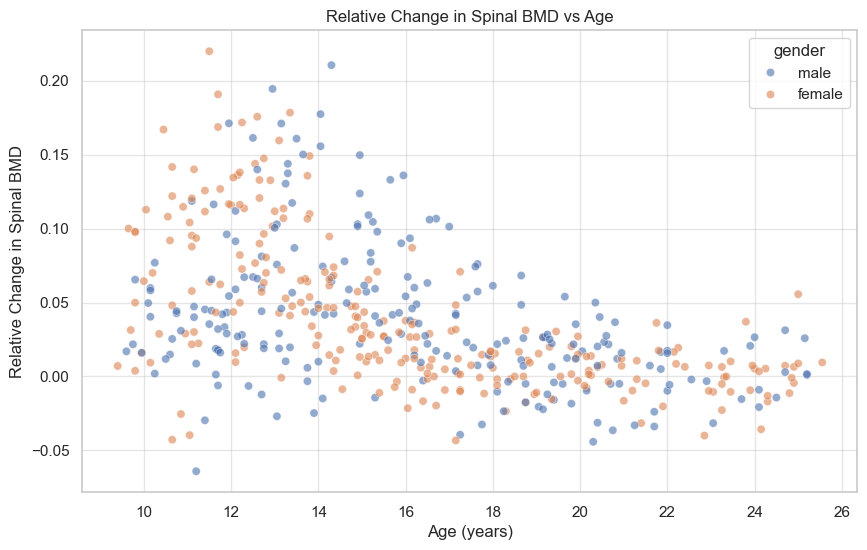

In [6]:
# Create scatter plot of spnbmd vs age
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bone_data, x='age', y='spnbmd', hue='gender', alpha=0.6)
plt.title('Relative Change in Spinal BMD vs Age')
plt.xlabel('Age (years)')
plt.ylabel('Relative Change in Spinal BMD')
plt.show()